# BAYESIAN OPTIMAL EXPERIMENT DESIGN

In [1]:
import torch
import pyro
import pyro.distributions as dist

sensitivity = 1.0
prior_mean = torch.tensor(7.0)
prior_sd = torch.tensor(2.0)


def model(l):
    # Dimension -1 of `l` represents the number of rounds
    # Other dimensions are batch dimensions: we indicate this with a plate_stack
    with pyro.plate_stack("plate", l.shape[:-1]):
        theta = pyro.sample("theta", dist.Normal(prior_mean, prior_sd))
        # Share theta across the number of rounds of the experiment
        # This represents repeatedly testing the same participant
        theta = theta.unsqueeze(-1)
        # This define a *logistic regression* model for y
        logit_p = sensitivity * (theta - l)
        # The event shape represents responses from the same participant
        y = pyro.sample("y", dist.Bernoulli(logits=logit_p).to_event(1))
        return y

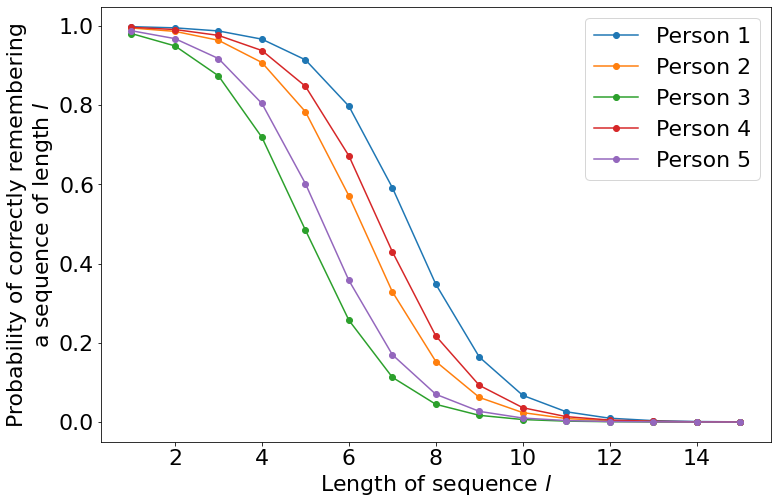

In [2]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 22})

# We sample five times from the prior
theta = (prior_mean + prior_sd * torch.randn((5,1)))
l = torch.arange(1, 16, dtype=torch.float)
# This is the same as using 'logits=' in the prior above
prob = torch.sigmoid(sensitivity * (theta - l))

plt.figure(figsize=(12, 8))
for curve in torch.unbind(prob, 0):
    plt.plot(l.numpy(), curve.numpy(), marker='o')
plt.xlabel("Length of sequence $l$")
plt.ylabel("Probability of correctly remembering\na sequence of length $l$")
plt.legend(["Person {}".format(i+1) for i in range(5)])
plt.show()

In [3]:
from torch.distributions.constraints import positive

def guide(l):
    # The guide is initialised at the prior
    posterior_mean = pyro.param("posterior_mean", prior_mean.clone())
    posterior_sd = pyro.param("posterior_sd", prior_sd.clone(), constraint=positive)
    pyro.sample("theta", dist.Normal(posterior_mean, posterior_sd))

In [4]:
l_data = torch.tensor([5., 7., 9.])
y_data = torch.tensor([1., 1., 0.])

In [5]:
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

conditioned_model = pyro.condition(model, {"y": y_data})
svi = SVI(conditioned_model,
          guide,
          Adam({"lr": .001}),
          loss=Trace_ELBO(),
          num_samples=100)
pyro.clear_param_store()
num_iters = 5000
for i in range(num_iters):
    elbo = svi.step(l_data)
    if i % 500 == 0:
        print("Neg ELBO:", elbo)

/users/afengler/data/software/miniconda3/envs/lanfactory/lib/python3.7/site-packages/pyro/infer/svi.py:61: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  FutureWarning,


Neg ELBO: 1.625186562538147
Neg ELBO: 0.9801537990570068
Neg ELBO: 1.4188510179519653
Neg ELBO: 1.1320440769195557
Neg ELBO: 1.127275824546814
Neg ELBO: 1.6807340383529663
Neg ELBO: 1.1953520774841309
Neg ELBO: 1.25933837890625
Neg ELBO: 1.261713981628418
Neg ELBO: 1.2512400150299072


In [6]:
print("Prior:     N({:.3f}, {:.3f})".format(prior_mean, prior_sd))
print("Posterior: N({:.3f}, {:.3f})".format(pyro.param("posterior_mean"),
                                            pyro.param("posterior_sd")))

Prior:     N(7.000, 2.000)
Posterior: N(7.701, 1.226)
